<a href="https://colab.research.google.com/github/faransikandar/Insight_AI_LSTM_Text_Generator/blob/master/Insight_AI_LSTM_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Text Generator

## Faran Sikandar
## 4/10/2019

# Preliminaries:

Thanks to tutorials:

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# Check Libraries

In [1]:
# show which version of keras working
!pip show tensorflow

Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, grpcio, absl-py, numpy, gast, six, wheel, astor, termcolor, protobuf, tensorflow-estimator, tensorboard, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
# show which hversion of keras
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, keras-preprocessing, h5py, numpy, pyyaml, keras-applications, six
Required-by: 


In [3]:
# check GPU connection
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# ETL - Extract, Transform, Load

In [0]:
# import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

## ETL Pipelines

https://colab.research.google.com/notebooks/io.ipynb#scrollTo=1aNyFO958V13
https://developers.google.com/drive/api/v3/manage-uploads

In [0]:
# # upload wonderland.txt file - could also mount Google Drive or use PyDrive, but this is simplest for small files
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [6]:
# mount Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# set up Drive REST API for more advanced functions

# authenticate
from google.colab import auth
auth.authenticate_user()

In [0]:
# construct Drive API client
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

## Get the Data

In [0]:
# function to upload ascii text and convert it to lowercase - return to memory
def load_text(filename):
  '''
  parameters: filename you want to upload
  output: text in lowercase
  '''
  
  # open file as read only
  f = open(filename, 'r')
  # read all text
  text = f.read()
  text = text.lower()
  
  # duplicate the text - like bootstrapping!
  text = text + ' ' + text
  
  # close the file
  f.close()
  return text

In [10]:
# upload wonderland.txt from Google Drive and preview
in_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland.txt'
text = load_text(in_filename)
print(text[:200])

alice’s adventures in wonderland

lewis carroll

the millennium fulcrum edition 3.0




chapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on the
bank, and


In [0]:
# function to create mapping of unique chars to integers - this step is faulty as integers imply order to letters - should use one-hot encoding, can remove punctuation
def map_char_to_int(text):
  '''
  parameters: doc from load_doc()
  output: chars - all unique chars, 
          char_to_int mapping (dictionary)
          int_to_char mapping (dictionary)
  '''

  # creates unique list
  chars = sorted(list(set(text))) 

  # create char to int dictionary
  char_to_int = dict((c, i) for i, c in enumerate(chars)) # enumerate creates mapping of tuples ((0, 'a',), (1, 'b'), etc)
  
  # create reverse dictionary to convert ints back to chars - will be used in text generator phase
  int_to_char = dict((i, c) for i, c in enumerate(chars))

  return (chars, char_to_int, int_to_char)

In [12]:
# execute mapping of unique chars to integers
chars = map_char_to_int(text)[0]
char_to_int = map_char_to_int(text)[1]
int_to_char = map_char_to_int(text)[2]
char_to_int

{'\n': 0,
 ' ': 1,
 '!': 2,
 '(': 3,
 ')': 4,
 '*': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '3': 10,
 ':': 11,
 ';': 12,
 '?': 13,
 '[': 14,
 ']': 15,
 '_': 16,
 'a': 17,
 'b': 18,
 'c': 19,
 'd': 20,
 'e': 21,
 'f': 22,
 'g': 23,
 'h': 24,
 'i': 25,
 'j': 26,
 'k': 27,
 'l': 28,
 'm': 29,
 'n': 30,
 'o': 31,
 'p': 32,
 'q': 33,
 'r': 34,
 's': 35,
 't': 36,
 'u': 37,
 'v': 38,
 'w': 39,
 'x': 40,
 'y': 41,
 'z': 42,
 '‘': 43,
 '’': 44,
 '“': 45,
 '”': 46}

In [0]:
# pickle the characters and dictionaries - will speed up re-modeling and text gen if disconnect from kernel

# set file names
pickle_chars_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland_chars.data'
pickle_char_to_int_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland_char_to_int.data'
pickle_int_to_char_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland_int_to_char.data'

# chars
with open(pickle_chars_filename, 'wb') as filename:  
    # store the data as binary data stream
    pickle.dump(chars, filename)

# char_to_int
with open(pickle_char_to_int_filename, 'wb') as filename:  
    # store the data as binary data stream
    pickle.dump(char_to_int, filename)

# int_to_char
with open(pickle_int_to_char_filename, 'wb') as filename:  
  # store the data as binary data stream
  pickle.dump(int_to_char, filename)

In [0]:
# summarize the dataset
def n_chars_vocab(text, char_to_int):
  '''
  parameters: text, char_to_int
  output: n_chars, n_vocab
  '''

  # count the chars
  n_chars = len(text)
  n_vocab = len(chars)
  return (n_chars, n_vocab)

In [15]:
# try the summary
n_chars = n_chars_vocab(text, char_to_int)[0]
n_vocab = n_chars_vocab(text, char_to_int)[1]

print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  288825
Total Vocab:  47


In [0]:
# prepare the dataset of input to output pairs encoded as integers
def map_patterns(text, n_chars, seq_length):
  '''
  parameters: text - to read,
              n_chars - number of characters in whole file
              seq_length - window frame to sequence file on
  outputs: dataX - all patterns for input
           dataY - next predicted character
           n_patterns - number of patterns
  '''
    
  # parse the sequences

  dataX = []
  dataY = []
  for i in range(0, n_chars - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
  n_patterns = len(dataX)
  return (dataX, dataY, n_patterns)

In [17]:
# execute the map of patterns to get the dataset of input to output pairs encoded as integers
seq_length = 100

patterns_info = map_patterns(text, n_chars, seq_length)

dataX = patterns_info[0]
dataY = patterns_info[1]
n_patterns = patterns_info[2]

print("Total Patterns: ", n_patterns)

Total Patterns:  288725


In [0]:
# save tokens to file - one pattern at a line
def save_patterns(data, filename):
  file = open(filename, 'w')
  for item in data:
    file.write("%s\n" % str(item))
  file.close()

In [0]:
# # save patterns to file - 
# out_dataX_filename = 'wonderland_dataX.txt' # use full path to get into a certain directory
# save_patterns(dataX, out_dataX_filename)

In [0]:
# use pickle to dump dataX pattern as binary stream
pickle_dataX_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland_dataX.data'

with open(pickle_dataX_filename, 'wb') as filename:  
    # store the data as binary data stream
    pickle.dump(dataX, filename)

In [0]:
# use pickle to get dataX back - just a check
with open(pickle_dataX_filename, 'rb') as filename:  
    # read the data as binary data stream
    dataX = pickle.load(filename)

In [0]:
# use pickle to dump dataY pattern as binary stream
pickle_dataY_filename = '/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/data/wonderland_dataY.data'

with open(pickle_dataY_filename, 'wb') as filename:  
    # store the data as binary data stream
    pickle.dump(dataY, filename)

In [0]:
def reshape_patterns(dataX, dataY, n_patterns, n_vocab, seq_length):
  '''
  parameters: dataX, dataY, n_patterns, n_vocab, seq_length
  outputs: X array - [samples, time steps, features]
           Y array - one-hot encoded prediction
  '''
  
  # reshape X to be [samples, time steps, features] for reading into keras + one-hot encode
  X = np.reshape(dataX, (n_patterns, seq_length, 1))
  
  # one-hot encode the inputs
  X = np_utils.to_categorical(X)
  
#   # normalize X - not necessary if doing one-hot - this implies some sort of a rank to the inputs
#   X = X / float(n_vocab) 
  
  # one-hot encode the output variable
  Y = np_utils.to_categorical(dataY)
  return (X, Y)

In [0]:
reshape_info = reshape_patterns(dataX, dataY, n_patterns, n_vocab, seq_length)
X = reshape_info[0]
Y = reshape_info[1]

In [24]:
X[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Define + Train + Fit Baseline LSTM Model

Note on training metrics: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence.

We are not interested in the most accurate (classification accuracy) model of the training dataset. This would be a model that predicts each character in the training dataset perfectly. Instead we are interested in a generalization of the dataset that minimizes the chosen loss function. We are seeking a balance between generalization and overfitting but short of memorization.

In [25]:
# define LSTM model
model = Sequential()
model.add(LSTM(256, input_shape = (X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(Y.shape[1], activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# define the checkpoint
filepath="/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/model/baseline-weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [27]:
# fit the model
history_baseline = model.fit(X, Y, epochs=20, batch_size=128, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
288725/288725 [==============================] - 469s 2ms/step - loss: 2.2129 - acc: 0.3764

Epoch 00001: loss improved from inf to 2.21286, saving model to /content/gdrive/My Drive/Colab_Notebooks/Insight_AI/model/baseline-weights-improvement-01-2.2129.hdf5
Epoch 2/20
288725/288725 [==============================] - 468s 2ms/step - loss: 1.7154 - acc: 0.4977

Epoch 00002: loss improved from 2.21286 to 1.71542, saving model to /content/gdrive/My Drive/Colab_Notebooks/Insight_AI/model/baseline-weights-improvement-02-1.7154.hdf5
Epoch 3/20
288725/288725 [==============================] - 466s 2ms/step - loss: 1.5222 - acc: 0.5473

Epoch 00003: loss improved from 1.71542 to 1.52217, saving model to /content/gdrive/My Drive/Colab_Notebooks/Insight_AI/model/baseline-weights-improvement-03-1.5222.hdf5
Epoch 4/20
288725/288725 [==============================] - 466s 2ms/step - loss: 1.3958 - acc: 0.5804

Epoch 00004: loss improved fro

## Plot model metrics

Note on plotting: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

The plots can provide an indication of useful things about the training of the model, such as:

- It’s speed of convergence over epochs (slope).
- Whether the model may have already converged (plateau of the line).
- Whether the mode may be over-learning the training data (inflection for validation line).

In [30]:
# list all data in history
print(history_baseline.history.keys())

dict_keys(['loss', 'acc'])


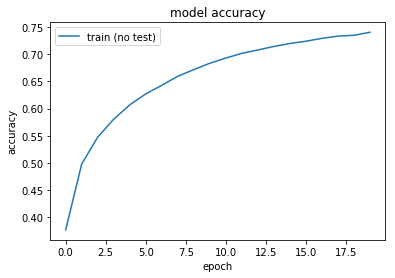

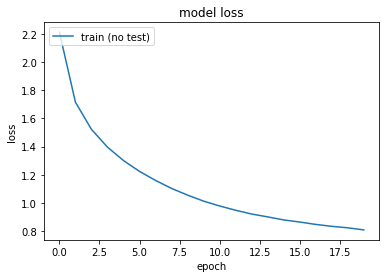

In [33]:
# plot history for accuracy
plt.plot(history_baseline.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train (no test)'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_baseline.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train (no test)'], loc='upper left')
plt.show()

# Generate Text from the LSTM Network - 1st Pass

In [34]:
# use Drive REST API to get list of models and select the one with the lowest loss
page_token = None
while True:
    response = drive_service.files().list(q="name contains 'weights-improvement'",
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name, parents)',
                                          pageToken=page_token).execute()
    for file in response.get('files', []):
        # Process change
        print('Found file: %s (id: %s) (parents: %s)' % (file.get('name'), file.get('id'), file.get('parents')))
    page_token = response.get('nextPageToken', None)
    if page_token is None:
        break

Found file: baseline-weights-improvement-20-0.8073.hdf5 (id: 10guEFOUQw0A52n2zl4laK8gq_sa0KRo4) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-19-0.8223.hdf5 (id: 10eNjyEWlGsZvxCapHFAkRc-o1XbiLg8y) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-18-0.8328.hdf5 (id: 10Tvxz5aJM4HqOi0VRgAsNCUwG2iplYax) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-17-0.8464.hdf5 (id: 10Rd_3H7ZY5YopHAR5EPOCkl7SL9NZmn6) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-16-0.8634.hdf5 (id: 10M52JBq6aohqamIeqP__xeA37TTODqWm) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-15-0.8784.hdf5 (id: 10KUaWSuR7lKeaE3iUqpw-y8aPGAHfELS) (parents: ['1qJL306_2_9zT2C0X6FjNylJgJqZfUJEF'])
Found file: baseline-weights-improvement-14-0.8999.hdf5 (id: 10IuT2jnMVz1PoGe8hYNwfeQlX2OntlTl) (parents: ['1qJL306_2_9zT2C0X6FjNy

In [0]:
# load the network weights by manually finding the model with the lowest loss above
model_filename = "/content/gdrive/My Drive/Colab_Notebooks/Insight_AI/model/baseline-weights-improvement-20-0.8073.hdf5"
model.load_weights(model_filename)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [150]:
# check X's shape for transformation of dataX to one-hot
X.shape

(288725, 100, 47)

In [181]:
np.reshape(pattern, (1, 100, 1)).shape

(1, 100, 1)

In [164]:
# generate seed for priming

# pick a random seed
start = np.random.randint(0, len(dataX) - 1)
pattern = dataX[start]
print("SEED:\n")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate prediction!!!

# model.predict is expecting input shape (100, 47) - dataX is a list of lists - pattern will be array (100, 1), while X is a transformed array (100, 47)

# choose prediction length
text_length = 1000

print("\nHERE'S YOUR GENERATED TEXT: \n")
# generate characters
for i in range(text_length):
  x = np.reshape(pattern, (1, len(pattern), 1))
#   x = x / float(n_vocab) # only if normalized - using one-hot instead	
  x = np_utils.to_categorical(x, num_classes=X.shape[2]) # one-hot encoding
  prediction = model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[value] for value in pattern]
  sys.stdout.write(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]
print("\nDone.")

SEED:

" he soon
made out that she was in the pool of tears which she had wept when she
was nine feet high.

 "

HERE'S YOUR GENERATED TEXT: 

‘i wish i hadn’t gone about it,’ said alice.

‘it may have any more than that,’ said the caterpillar.

‘well, i what a dided the arches, i should think,’ said alice, ‘i managed to see after that it does and the march hare.

  ‘it may be off, in that door, i shall see at the end of the stir--of course, what a but on her such as me the hatter
wordered about that in the same and me nive about it, and thinking when they all the thing thing the pool a little bottle
without a little way off, and the white rabbit was she went on, ‘and that’s all the treacle, but she would go to the
conversation, and see shake she had any
door as she was spraising a little starts, and the oncees of the trees and a pleased tone, ‘there’s no use in the simpled
sounder!’ (when she thought to her feet at the thing it had been and looked at the
bany, and the white rabbit was

# Revised Model

# Testing Area

In [98]:
text_test = "Hi, my name is Faran Sikandar and I like basketball. Hello."
text_test

'Hi, my name is Faran Sikandar and I like basketball. Hello.'

In [100]:
characters_test = sorted(list(set(text)))
characters_to_int = dict((c, i) for i, c in enumerate(characters))
characters_to_int

{'\n': 0,
 ' ': 1,
 '!': 2,
 '(': 3,
 ')': 4,
 '*': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '3': 10,
 ':': 11,
 ';': 12,
 '?': 13,
 '[': 14,
 ']': 15,
 '_': 16,
 'a': 17,
 'b': 18,
 'c': 19,
 'd': 20,
 'e': 21,
 'f': 22,
 'g': 23,
 'h': 24,
 'i': 25,
 'j': 26,
 'k': 27,
 'l': 28,
 'm': 29,
 'n': 30,
 'o': 31,
 'p': 32,
 'q': 33,
 'r': 34,
 's': 35,
 't': 36,
 'u': 37,
 'v': 38,
 'w': 39,
 'x': 40,
 'y': 41,
 'z': 42,
 '‘': 43,
 '’': 44,
 '“': 45,
 '”': 46}

In [0]:
list_test = list(text_test)

In [102]:
list_test

['H',
 'i',
 ',',
 ' ',
 'm',
 'y',
 ' ',
 'n',
 'a',
 'm',
 'e',
 ' ',
 'i',
 's',
 ' ',
 'F',
 'a',
 'r',
 'a',
 'n',
 ' ',
 'S',
 'i',
 'k',
 'a',
 'n',
 'd',
 'a',
 'r',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'I',
 ' ',
 'l',
 'i',
 'k',
 'e',
 ' ',
 'b',
 'a',
 's',
 'k',
 'e',
 't',
 'b',
 'a',
 'l',
 'l',
 '.',
 ' ',
 'H',
 'e',
 'l',
 'l',
 'o',
 '.']

In [103]:
list_test[::-1]

['.',
 'o',
 'l',
 'l',
 'e',
 'H',
 ' ',
 '.',
 'l',
 'l',
 'a',
 'b',
 't',
 'e',
 'k',
 's',
 'a',
 'b',
 ' ',
 'e',
 'k',
 'i',
 'l',
 ' ',
 'I',
 ' ',
 'd',
 'n',
 'a',
 ' ',
 'r',
 'a',
 'd',
 'n',
 'a',
 'k',
 'i',
 'S',
 ' ',
 'n',
 'a',
 'r',
 'a',
 'F',
 ' ',
 's',
 'i',
 ' ',
 'e',
 'm',
 'a',
 'n',
 ' ',
 'y',
 'm',
 ' ',
 ',',
 'i',
 'H']